## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# We used Jarvis so kept all the below install/download command

!pip install spacy
!pip install plotly
!pip install wordcloud

import nltk, spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to C:\Users\Ravi
[nltk_data]     Teja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Ravi
[nltk_data]     Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ravi
[nltk_data]     Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-11-04 11:00:11.238685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-11-04 11:00:11.238773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# importing all the libraries

import json 
import numpy as np
import pandas as pd

import re, nltk, spacy, string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file.
# Write the path to your data file and load it 
f = open('complaints-2021-05-14_08_16.json', 'r')

# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data

print("Shape of dataframe:-", df.shape)

df.head()

Shape of dataframe:- (78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

#### Comment about renaming columns:
- All the column name is having suffix as `_source` except the first 4 columns
- First add above suffix to first 4 columns also
- Then rename all the columns to remove suffux `_source`
- Reduce the columns name `complaint_what_happened` to `complaints`

In [6]:
#Assign new column names

df.rename({'_index': '_source.index', '_type': '_source.type','_id': '_source.id', '_score': '_source.score'}, axis=1, inplace=True)
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename({'complaint_what_happened': 'complaints'}, axis=1, inplace=True)

# print new column names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Use regex to assign nan in place of blanks in the complaints column

df['complaints'] = df['complaints'].replace(r'^\s*$', np.nan, regex=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [8]:
#Remove all rows where complaints column is nan

df.dropna(subset = ["complaints"], inplace=True)

In [9]:
# Print shape of df after cleaning the dataset
print("Shape of dataframe:-", df.shape)

# print the head also
df.head()

Shape of dataframe:- (21072, 22)


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(df):
    
    df['complaints'] = df['complaints'].apply(lambda x: x.lower()) # Make text in lower case
    df['complaints'] = df['complaints'].apply(lambda x: x.replace("\n","")) # Remove new line char
    df['complaints'] = df['complaints'].replace(r'(\w*\d\w*)', '', regex=True) # Remove word containing numbers
    df['complaints'] = df['complaints'].replace(r'[^\w\s]', '', regex=True) # Remove punctuation
    df['complaints'] = df['complaints'].replace(r'\([^)]*\)|\{[^)]*\}|\[[^)]*\]', '', regex=True) #Remove text in square bracket
    
    return df.head()

In [11]:
# Call the clean_text column to clean complaint column

clean_text(df)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xxxx and was t...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on xxxx however fraudu...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on xxxx while trying to book a xxxx xxxx tic...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided


In [12]:
# Create a complaint list from df.complaints column

com_list = df.complaints.tolist()

# Print couple of sentences
com_list[:3]

['good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help',
 'i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me',
 'chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without v

In [13]:
#Write your function to Lemmatize the texts

stop_words = stopwords.words("english")

def preprocess(document):
    'removes stopwords and lemmatizes the remainder of the sentence'

    # tokenize into words
    words = word_tokenize(document)
    
    words = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in words if word not in stop_words]

    # join words to make sentence
    document = " ".join(words)
    
    return document

In [14]:
# call preprocess function to create lemmatization list using complaint list
wordnet_lemmatizer = WordNetLemmatizer()

lemma_list = [preprocess(sentence) for sentence in com_list]

# print couple of sentences from lemmatize list
lemma_list[:3]

['good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help',
 'upgraded xxxx xxxx card xxxx told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled',
 'chase card reported xxxx however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant']

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(list(zip(com_list, lemma_list)), columns =['complaint', 'lemma_Com'])

# print head
df_clean.head()

,complaint,lemma_Com
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [16]:
#Write your function to extract the POS tags (Keep only NN Pos tags)

import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])

def get_POS_tags(document):
    #pos_tags = ""
    words = ""
       
    tagged_sentence = nlp(document)
    
    for token in tagged_sentence:
        if token.pos_ == "NOUN":
            words += token.text + " " 
    
    return words
    #return words,pos_tags

In [17]:
# call get_POS_tags function to get the words with NOUN POS tags only.  Create a new list com_after_rem_pos.

com_after_rem_pos = [get_POS_tags(sentence) for sentence in com_list]

# Print first couple of lines
com_after_rem_pos[:3]

['morning name stop services debt verification statement bank debt mail month debt right information consumer chase xxxx xxxx xxxx xxxx thanks advance help ',
 'xxxx card agent anniversary date agent information order account anniversary date consent xxxx recording agent ',
 'application identity consent services credit identity applicant ']

In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

# add column complaint after removing POS tags
df_clean['com_after_rem_pos'] = com_after_rem_pos

df_clean.head()

,complaint,lemma_Com,com_after_rem_pos
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop services debt verification s...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




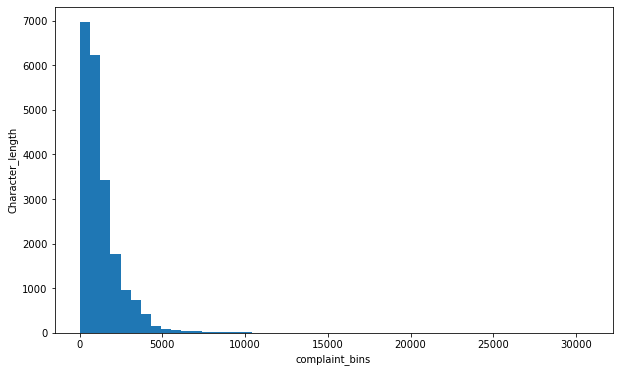

In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint]
plt.hist(doc_lens, bins = 50)
plt.xlabel('complaint_bins')
plt.ylabel('Character_length');

#### Find the top 40 words by frequency among all the articles after processing the text.

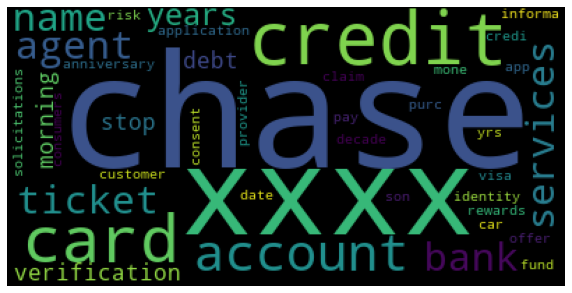

In [20]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.com_after_rem_pos))

print(wordcloud)
plt.figure(figsize=(10,6))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [21]:
print(spacy.__version__)

#Removing -PRON- from the text corpus
#df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

3.1.2


####  Since we are using new version of spacy we don't need to perfom above step.

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# function to find the top n unigram
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0) 
      
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [23]:
# finding the top 30 unigrams

common_words_uni = get_top_n_unigram(df_clean.com_after_rem_pos, 30)

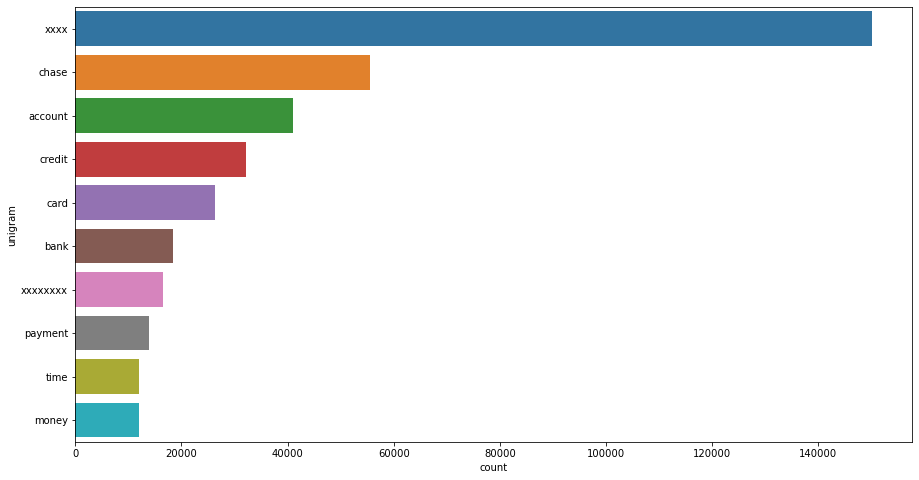

In [24]:
#plotting the top 10 words in the unigram frequency

plt.figure(figsize=(15,8))
df_uni = pd.DataFrame(common_words_uni[0:10], columns = ['unigram' , 'count'])
fig = sns.barplot(y=df_uni['unigram'], x=df_uni['count'])

In [25]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# function to find the top n bigram

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
       
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

In [26]:
# finding the top 30 bigrams

common_words_bi = get_top_n_bigram(df_clean.com_after_rem_pos, 30)

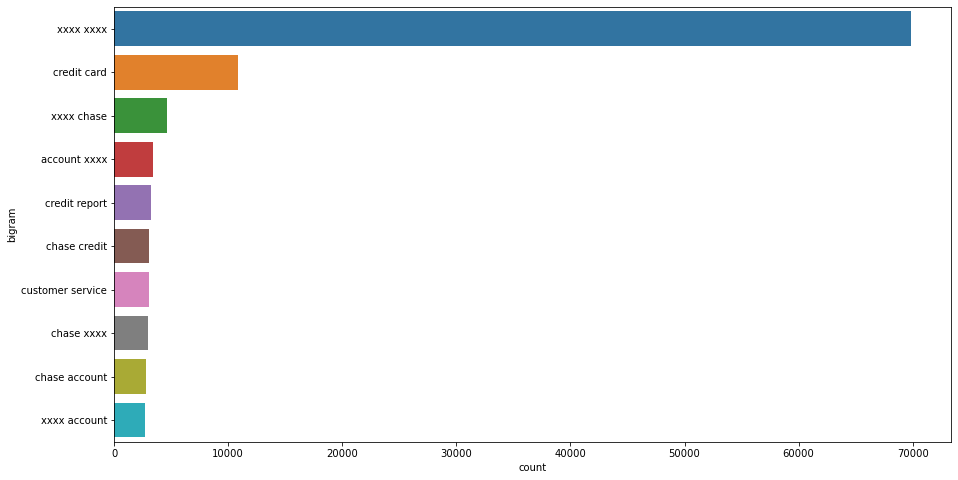

In [27]:
#Plotting the top 10 words in the bigram frequency

plt.figure(figsize=(15,8))
df_bi = pd.DataFrame(common_words_bi[0:10], columns = ['bigram' , 'count'])
fig = sns.barplot(y=df_bi['bigram'], x=df_bi['count'])

In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# function to find the top n trigrams

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [29]:
#Plotting the top 10 words in the trigram frequency

common_words_tri = get_top_n_trigram(df_clean.com_after_rem_pos, 30)

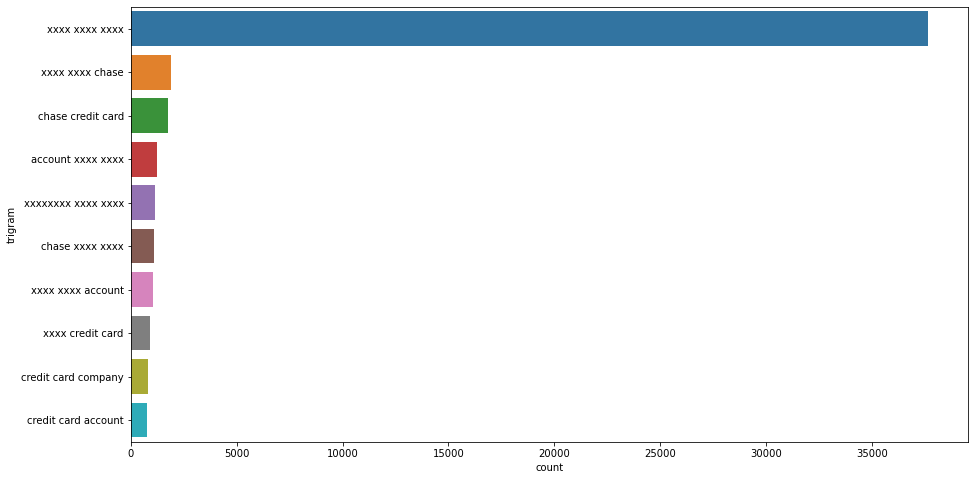

In [30]:
# plotting the top-10 trigrams

plt.figure(figsize=(15,8))
df_tri = pd.DataFrame(common_words_tri[0:10], columns = ['trigram' , 'count'])
fig = sns.barplot(y=df_tri['trigram'], x=df_tri['count'])

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
# remove 'xxxx'

df_clean['com_after_rem_pos'] = df_clean['com_after_rem_pos'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed

df_clean

,complaint,lemma_Com,com_after_rem_pos
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop services debt verification s...
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information...
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket rewards card informatio...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...
...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,visa credit card provider claim purchase pro...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom pr...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean.com_after_rem_pos)

In [35]:
print(dtm)

  (0, 3415)	0.20186483360424326
  (0, 152)	0.2665870318656094
  (0, 7264)	0.2676103616409039
  (0, 1222)	0.06972291166781643
  (0, 1629)	0.19150580651547303
  (0, 3707)	0.12882856279966398
  (0, 6252)	0.24240024613512942
  (0, 4637)	0.1597306457672256
  (0, 4297)	0.18238154176679106
  (0, 631)	0.10577024260243152
  (0, 6886)	0.1731357634381153
  (0, 7730)	0.25671395393574636
  (0, 1969)	0.5653820458690124
  (0, 6537)	0.1962784456831296
  (0, 6942)	0.3076486323804261
  (0, 4739)	0.1616126360221739
  (0, 4653)	0.23427653189727984
  (1, 5925)	0.2594425929986445
  (1, 1602)	0.2272474005140972
  (1, 45)	0.07134526112701214
  (1, 5006)	0.16008041522581543
  (1, 1919)	0.2779653382856332
  (1, 326)	0.6520898857917524
  (1, 211)	0.5731994970749503
  (1, 1053)	0.08471405080442439
  :	:
  (21070, 5201)	0.3626220468684803
  (21070, 5205)	0.06029584364635642
  (21070, 6115)	0.14177418163343272
  (21070, 1816)	0.146456951459105
  (21070, 1053)	0.16159437067948934
  (21070, 1222)	0.19883075127831845


In [36]:
dtm.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
# get feature names using tfidf.get_feature_names()

pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aa,aaaratings,aarp,abandonment,abatement,abbreviation,abd,abide,abilities,ability,...,youth,yr,yrs,zeros,zilch,zip,zipcode,zombie,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.142807,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [38]:
# import NMF library

from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

### We have tried the 8 and 10 topics as well and found out that 5 is the best num of topics

In [39]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [40]:
nmf_model.fit(dtm)

print(len(tfidf.get_feature_names()))

8060


In [41]:
# Document-topic matrix
W1 = nmf_model.fit_transform(dtm)

# Topic-term matrix
H1 = nmf_model.components_

In [42]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H1[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,funds,branch,checking,deposit,accounts,number,days,business,checks,fraud
Topic 2,card,chase,charges,charge,credit,dispute,fraud,merchant,transaction,company,purchase,phone,claim,service,number
Topic 3,loan,mortgage,chase,home,modification,property,payments,foreclosure,years,house,letter,time,sale,documents,rate
Topic 4,credit,report,inquiry,card,inquiries,score,cards,accounts,account,debt,reporting,information,limit,bureaus,reports
Topic 5,payment,balance,payments,interest,month,fees,fee,statement,amount,date,bill,time,auto,chase,rate


In [43]:
H1 = pd.DataFrame(H1, index=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'], columns=tfidf.get_feature_names())
H1

,aa,aaaratings,aarp,abandonment,abatement,abbreviation,abd,abide,abilities,ability,...,youth,yr,yrs,zeros,zilch,zip,zipcode,zombie,zone,zones
Topic 1,0.000348,0.00000,0.000000,0.000000,0.000118,0.000000,0.001164,0.000000,0.000847,0.028642,...,0.000781,0.000000,0.001289,0.001580,0.000805,0.001235,0.000044,0.000000e+00,0.001087,0.000000
Topic 2,0.000264,0.00000,0.013810,0.000000,0.000000,0.000086,0.000688,0.001005,0.000068,0.011440,...,0.000000,0.000521,0.003819,0.000699,0.000000,0.006167,0.000000,8.454601e-07,0.001831,0.000091
Topic 3,0.000802,0.00098,0.000359,0.001073,0.001484,0.000945,0.000000,0.000316,0.002349,0.039834,...,0.000030,0.008581,0.024144,0.000000,0.000024,0.001871,0.000269,2.115196e-03,0.003791,0.000000
Topic 4,0.000000,0.00000,0.003450,0.000000,0.000000,0.000000,0.000000,0.000029,0.000000,0.038812,...,0.000000,0.000000,0.003117,0.000100,0.000000,0.002754,0.000090,1.167341e-03,0.000000,0.000000
Topic 5,0.000305,0.00000,0.000000,0.000000,0.000011,0.000000,0.000080,0.000013,0.000553,0.018947,...,0.000000,0.005287,0.001149,0.000043,0.000220,0.006187,0.000000,0.000000e+00,0.000218,0.003849


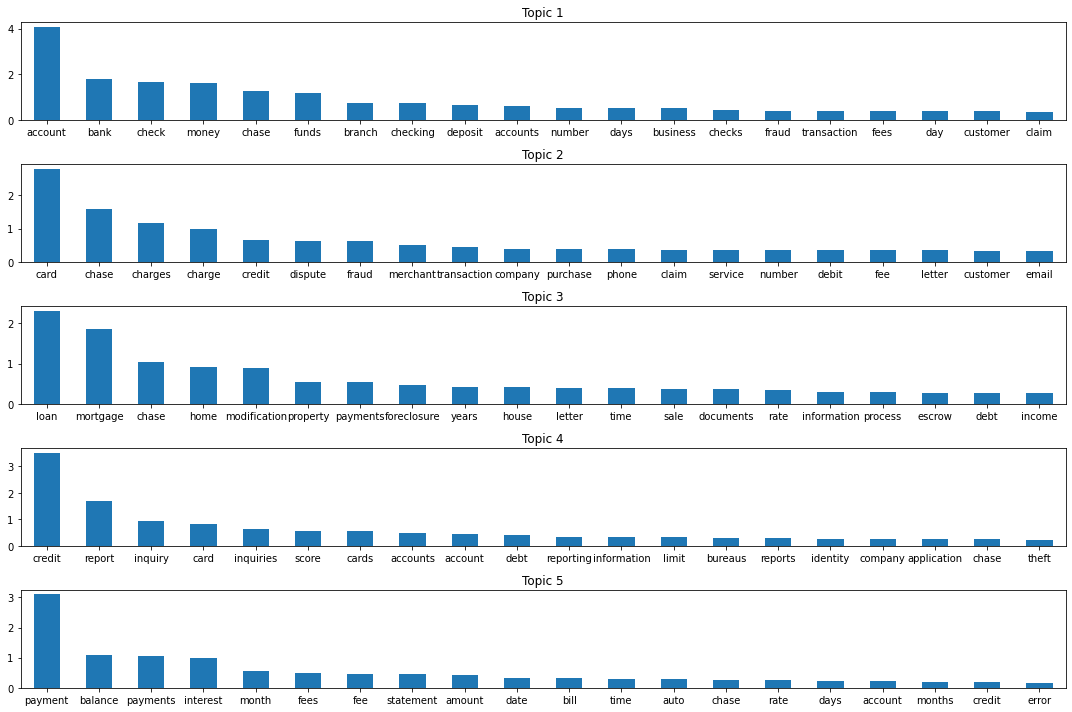

In [44]:
# Top words for each topic

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 10))
for i in range(5):
    words = H1.loc[f'Topic {i + 1}'].sort_values(ascending=False)[:20]
    words.plot(ax=ax[i], kind='bar', rot=0)
    ax[i].set_title(f'Topic {i + 1}')

plt.tight_layout()

### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
# After analysing the Topic 1-5 we have created the following topic mapping

topic_mapping = {
    'Topic 1': 'Other',
    'Topic 2': 'Theft/Dispute reporting',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Credit card / Prepaid card',
    'Topic 5': 'Bank account services'
}

In [46]:
# Recall the document-topic matrix, W1
#Assign the best topic to each of the cmplaints in Topic Column

W1 = pd.DataFrame(W1, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W1['max_topic'] = W1.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)

nmf_topics = W1[pd.notnull(W1['max_topic'])]
nmf_topics.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.010268,0.006990,0.018475,0.015013,0.010229,Mortgages/loans
1,0.008136,0.017275,0.001704,0.002018,0.003178,Theft/Dispute reporting
2,0.000000,0.000000,0.001668,0.036978,0.000000,Credit card / Prepaid card
3,0.016329,0.019443,0.012459,0.051507,0.000000,Credit card / Prepaid card
4,0.063648,0.009425,0.009501,0.000000,0.000000,Other
5,0.000000,0.000000,0.000000,0.045881,0.000000,Credit card / Prepaid card
6,0.064791,0.008307,0.005858,0.000000,0.007891,Other
7,0.002492,0.008271,0.033636,0.000000,0.051571,Bank account services
8,0.025531,0.044185,0.017344,0.000000,0.003608,Theft/Dispute reporting
9,0.000000,0.025160,0.000000,0.108848,0.000000,Credit card / Prepaid card


In [47]:
#Add the column `Topic` column to df_clean

df_clean['Topic'] = nmf_topics.max_topic #write your code to assign topics to each rows.

In [48]:
df_clean.head()

,complaint,lemma_Com,com_after_rem_pos,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop services debt verification s...,Mortgages/loans
1,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information...,Theft/Dispute reporting
2,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,Credit card / Prepaid card
3,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,ticket offer ticket rewards card informatio...,Credit card / Prepaid card
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,Other


In [49]:
# Verify some complaints and corresponding topics

for i in range(15000,15005):
    print(df_clean.complaint[i])
    print("Topic:", df_clean.Topic[i])
    print("--"*65)

i had an xxxx credit card when i was in college it was bought out by chase freedom in the process of changing companies i missed a monthly payment in i believe xxxxxxxx chase immediately penalized me by raising my interest rate to a borderline usury interest rate of   i graduated in xxxxxxxx into a bad job market and was underemployed for much of xxxxxxxx and xxxxxxxx which made it incredibly hard to pay down my balance while the absurd interest rate was being applied i eventually was able to pay off the balance since that time my credit has drastically increased and i have been able to buy a nice xxxx family home without a joint applicant or cosinger i have also been able to obtain new credit cards with competitive interest rates i have called chase freedom several times over the last couple years to have it lowered to a reasonable rate that is in line with my credit report during this same time period other credit cards that i use have lowered the interest rate on my cards without me

### After verifying the above 25-30 complaints and repective topics manually, we have found that the topics and the complaints are matching mostly and there are very few mismatches. This is the best topic-complaint mapping we have found.

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints. Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [50]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint', 'Topic']]

In [51]:
# training data

training_data

,complaint,Topic
0,good morning my name is xxxx xxxx and i apprec...,Mortgages/loans
1,i upgraded my xxxx xxxx card in xxxx and was t...,Theft/Dispute reporting
2,chase card was reported on xxxx however fraudu...,Credit card / Prepaid card
3,on xxxx while trying to book a xxxx xxxx tic...,Credit card / Prepaid card
4,my grand son give me check for i deposit it i...,Other
...,...,...
21067,after being a chase card customer for well ove...,Theft/Dispute reporting
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,Theft/Dispute reporting
21069,i am not familiar with xxxx pay and did not un...,Theft/Dispute reporting
21070,i have had flawless credit for yrs ive had ch...,Bank account services


#### Apply the supervised models on the training data created. In this process, you have to do the following:

* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Create the vector counts using Count Vectoriser
count_vect = CountVectorizer(max_df = 0.95, min_df = 2)

# Transform the word vecotr to tf-idf. we will use TfidfTransformer()

vectorized_complaint = count_vect.fit_transform(df_clean.complaint)
tfidf_transformer = TfidfTransformer()
tfidf_model = tfidf_transformer.fit_transform(vectorized_complaint)

In [53]:
# Map the target variable to numeric value. topics will be assigned value 0-4 as below.

df_clean['Topic'] = df_clean['Topic'].map({
    'Other': 0,
    'Theft/Dispute reporting': 1, 
    'Mortgages/loans': 2, 
    'Credit card / Prepaid card': 3,
    'Bank account services': 4
})

In [54]:
#create X and y variable

X = pd.DataFrame(tfidf_model.toarray(), columns=count_vect.get_feature_names())

y = df_clean['Topic']

X.head(5)

,__,___,____,_____,______,_______,________,_________,__________,_________________,...,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# value counts for each class

y.value_counts()

1    5791
0    5558
2    3696
3    3445
4    2582
Name: Topic, dtype: int64

In [56]:
# split the data into train and test

from sklearn.model_selection import train_test_split

# will split the 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size =0.3, random_state=100)

print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

train shape: (14750, 16521)
test shape: (6322, 16521)


You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Models:
- Create a function to calculate the accuracy score and print the confusion matrix 
- We have decided to create below models:
    1. Naive bayes (Bernoulli and Mutinomial)
    2. Random forest
    2. Logistic Regression

In [57]:
# import confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score

# function to print the accuracy and the confusion matrix
def get_metrics(y_train, y_pred_train, y_test, y_pred_test):
    print("Train Accuracy :", accuracy_score(y_true=y_train, y_pred = y_pred_train))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred_train))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_true=y_test, y_pred = y_pred_test))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))

### 1. Naive Bayes

In [58]:
# training the Bernoulli Naive Bayes model 
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(X_train,y_train)

BernoulliNB()

In [59]:
# predicting and getting the metrics for the train and test data
y_pred_train = bnb.predict(X_train)
y_pred_test = bnb.predict(X_test)

get_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train Accuracy : 0.6754576271186441
Train Confusion Matrix:
[[2840  112   56  852   58]
 [ 264 2505   33 1090  117]
 [  65   15 1649  661  191]
 [  59  181  110 1968  105]
 [ 121   72  135  490 1001]]
--------------------------------------------------
Test Accuracy : 0.6390382790256248
Test Confusion Matrix:
[[1116   79   42  368   35]
 [ 168 1034   24  488   68]
 [  32    6  724  277   76]
 [  29   86   46  807   54]
 [  81   48   62  213  359]]


In [60]:
# training the Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb=MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [61]:
# predicting and getting the metrics for the train and test data
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

get_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train Accuracy : 0.7541694915254237
Train Confusion Matrix:
[[3608  235   15   57    3]
 [ 341 3629    6   32    1]
 [ 256  153 2124   42    6]
 [ 255  734   62 1363    9]
 [ 507  600  242   70  400]]
--------------------------------------------------
Test Accuracy : 0.7274596646630813
Test Confusion Matrix:
[[1472  129   11   27    1]
 [ 209 1556    5   10    2]
 [ 133   71  887   23    1]
 [ 122  310   32  556    2]
 [ 220  296   97   22  128]]


## 2. Random Forest
- We have tuned the hyper-parameters and using the best parameters here to build the model

In [62]:
# training the Random Forest model
# We have tuned the hyper-parameters and using the best parameters here to build the model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, 
                                  n_jobs=-1, 
                                  max_depth =100, 
                                  min_samples_leaf = 150, 
                                  max_features = 1000,
                                  n_estimators = 300)

rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, max_features=1000, min_samples_leaf=150,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [63]:
# predicting and getting the metrics for the train and test data
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

get_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train Accuracy : 0.8326101694915254
Train Confusion Matrix:
[[3676  176   16   45    5]
 [ 299 3581   16  101   12]
 [ 143  120 2259   46   13]
 [  91  375   62 1876   19]
 [ 289  316  236   89  889]]
--------------------------------------------------
Test Accuracy : 0.8220499841822209
Test Confusion Matrix:
[[1513   92   13   19    3]
 [ 136 1582   11   48    5]
 [  80   48  960   21    6]
 [  38  162   31  782    9]
 [ 120  163   85   35  360]]


### 3. Logistic Regression

In [64]:
# training the Logistic regression model
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression().fit(X_train, y_train)

In [65]:
# predicting and getting the metrics for the train and test data
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

get_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train Accuracy : 0.9729491525423729
Train Confusion Matrix:
[[3865   27    4   18    4]
 [  43 3939    3   17    7]
 [  29   15 2522    9    6]
 [  30   48    8 2330    7]
 [  51   36   30    7 1695]]
--------------------------------------------------
Test Accuracy : 0.9283454602973743
Test Confusion Matrix:
[[1570   43   14    7    6]
 [  55 1695    7   17    8]
 [  36   16 1042   13    8]
 [  29   48   11  926    8]
 [  51   36   24   16  636]]


## Conclusion:

We have the below four models.
1. Bernoulli Naive Bayes - 64% Test accuracy
2. Multinomial Naive Bayes - 72.7% Test accuracy
3. Random Forest - 82.2% Test accuracy
4. Logistic Regression - 93% Test accuracy

#### Among all these Logistic regression is the best model as per the accuracy

## Model Inference

In [66]:
# Define some custom text
custom_text = "Applicable loan admin charge fee waiver is not applied on my loan account number xxxx-xxxxxx"

vectorized = tfidf_transformer.transform(count_vect.transform([custom_text]))
cust_x = pd.DataFrame(vectorized.toarray(), columns=count_vect.get_feature_names())

# make prediction
predictions = lm.predict(cust_x)

In [67]:
predictions

array([2], dtype=int64)

The topics label and the topics are as below 

0. Other
1. Theft/Dispute reporting
2. Mortgages/loans
3. Credit card / Prepaid card
4. Bank account services

### The final model (Logistic Regression) is able to correctly predict custom text as `Mortgages/loans`